In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy import stats

import sys; sys.path.insert(1, '/home/alessandro/thesis_material')
import os

import geometry as gm
#import conversion as cnv
from func_statistics import compute_pdf_nbin, slopes_r_p, slope_time, slope_maps
#from coare_functions import *

import meteo                    # wind_dir_speed
import metpy.calc as mpcalc
from metpy.units import units
import lcl

from windrose import WindroseAxes
import cartopy.crs as ccrs
crs = ccrs.PlateCarree()
#from plotmap import plot_background

from plotdistr import * #fb_distribution_npoint, perc_distribution, scatterplot_fit, hist2d, perc_distribution_pvalue
from pdist_fb_distrib_save_fast import *

import warnings; warnings.filterwarnings("ignore")

In [3]:
# find data
path = '/saturn/simu_Caribbean/coupled_2km/output/'
files_ls = ['QCLOUD', 'U', 'V', 'W', 'OLR', 'PH', 'PHB', 'QVAPOR', 'PB', 'P', 'T']
files_ls = [name + '.nc' for name in files_ls]
wrf_files = [path+name for name in files_ls]
#fname_list = sorted(glob.glob(wrf_files + '*'))

In [9]:
# import sea_mask
if os.path.exists('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy'):
    sea_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/masks/sea_mask_EU_noWarmPatch_noWest.npy')
#     sg_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_strongGrads.npy')
#     wg_mask = np.load('/home/alessandro/thesis_material/EURECA_scripts/sea_mask_EU_weakGrads.npy')

sea_mask_nan = sea_mask
sea_mask_nan[sea_mask_nan==0] = np.nan

In [5]:
# MATTE AVEVA GIA' CALCOLATO TUTTE LE CORRELAZIONI 
# E HA STIMATO QUESTA LUNGHEZZA?
L = 30
nskip = int(L/2)
nt = int(1)

# from top pbl upwards
# SOPRA PBL LA LUNGEHZZA DI CORRELAZIONE AUMENTA?
# NEL SENSO CHE I SEGNALI HANNO PIù SPAZIO PER PROPAGARSI?
Ltop = 150
nskiptop = int(Ltop/2)
nttop = int(1)

# reference population mean
popmean = 0.

In [7]:
U = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/U/U_day_feb.npy')
V = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/V/V_day_feb.npy')


In [10]:
dsst_day = dsst_day*sea_mask
U, V = U*sea_mask_nan, V*sea_mask_nan



In [11]:
# load W component - in m/s
W_day = xr.open_dataset(wrf_files[files_ls.index('W.nc')])
W_day = W_day['W'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))#.groupby('time_counter.day').mean()
W_day = W_day.where(sea_mask, drop=False)


W_inter = np.zeros_like(U)
for i in range(39):
    W_inter[:,i,:,:] = (W_day[:,i+1,:,:]+W_day[:,i,:,:])*0.5

In [12]:
lon_M = W_day['nav_lon_grid_M'].values
lat_M = W_day['nav_lat_grid_M'].values

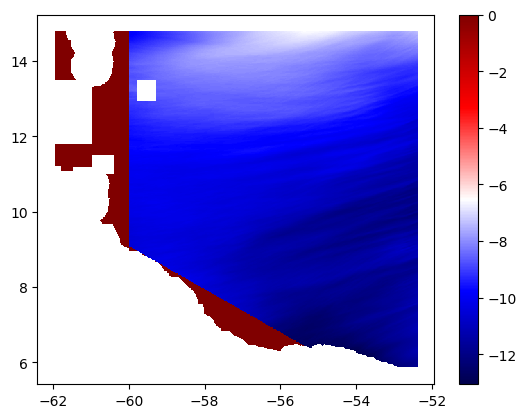

In [13]:
plt.pcolormesh(lon_M, lat_M, U[0,10,:,:], cmap='seismic')
plt.colorbar()

In [29]:
# compute anomalies daily data
s = 100

dw_day = np.zeros_like(W_day.values)

for t in range(0,W_day.values.shape[0]):
    if t % 10 == 0:
        print(t)
    
    for h in range(0,dw_day.shape[1]):
        w_ave = gm.nan_gaussian_filter(W_day.values[t,h],s)  
        dw_day[t,h] = W_day.values[t,h] - w_ave

0
10
20


In [31]:
my_save_data('/venus/tesi_ale/data_EU/WIND/daily/FEB/W/dw_day.npy', [dw_day])

In [14]:
dw_day = np.load('/venus/tesi_ale/data_EU/WIND/daily/FEB/W/dw_day.npy')

In [9]:
#### percentile distributionnssss

## W DISTRIBUTION
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_w, pstd_w, pstderr_w, pnpoints_w, ppvalue_w_sub = \
dist_3d_subsample(dsst_day, W_day.values, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


In [15]:
#### percentile distributionnssss

## W  anoms  DISTRIBUTION
perc_step = 5
nbins = int(100/perc_step) # Number of bins.

pdist_dsst, pdist_dw, pstd_dw, pstderr_dw, pnpoints_dw, ppvalue_dw_sub = \
dist_3d_subsample(dsst_day, dw_day, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

0
10
20
30


/venus/tesi_ale/img_EU/WIND/daily/FEB/pdist_dsst_dW_day_lowtropo.png


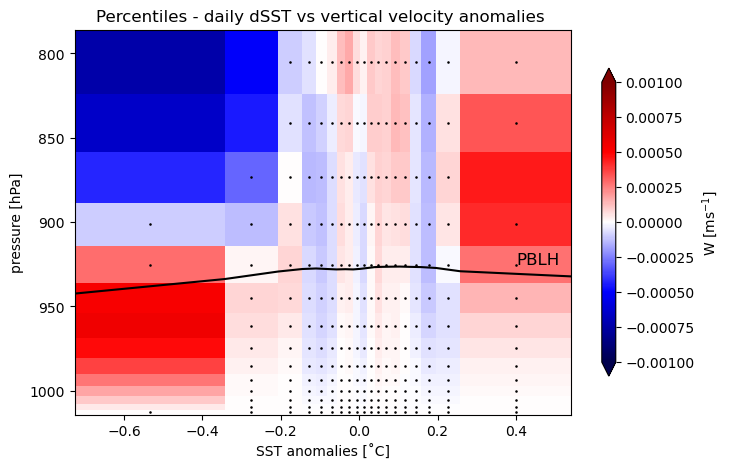

In [17]:
# figure W and dW vs dSST bin - DAILY
p_level_plot = int(15)

anoms = True

x = pdist_dsst 
var = pdist_dw[0:p_level_plot,:] if anoms else pdist_w[0:p_level_plot,:] 
minval = -0.001
maxval = -minval
title = 'Percentiles - daily dSST vs vertical velocity anomalies' if anoms else \
        'Percentiles - daily dSST vs vertical velocity'

fig, ax1 = plt.subplots(figsize=(8, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, vmin=minval, vmax=maxval, cmap='seismic')
ax1.set_xlabel('SST anomalies [˚C]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} ')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label(r'W [$\rm ms^{-1}$]')    #('$N^2$ anoms [$10^5 \cdot s^{-2}$]')


x_pbl = pdist_dsst 
var_pbl = pdist_PBLH_dsst #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
ax1.text(0.4, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
pval = ppvalue_dw_sub[0:p_level_plot] if anoms else ppvalue_w_sub[0:p_level_plot] 
GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
    cond1 = pval[h,:-1] > 0.05
    cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
    cond = (cond1) | (cond2)
#     cond = cond1
    signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
    signif_Lcorr_H[h, cond] = GPbin[h]
    dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


path_img = '/venus/tesi_ale/img_EU/WIND/daily/FEB/' 
filename = path_img + 'pdist_dsst_dW_day_lowtropo.png' if anoms else path_img + 'pdist_dsst_W_day_lowtropo.png' 
#plt.savefig(filename)
print(filename)
del filename

IN DAILY MEANS, ONLY THE GENERAL SUBSIDENCE IS VISIBLE

In [13]:
lat_reduced = lat_M[:,0]
exist_ = np.argwhere(lat_reduced==10.01075)
print(exist_)

[[253]]


In [45]:
# visualize what is going on along (-56, 7:14) and (-60:-53, 10)

vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))

In [25]:
# visualize what is going on along (-56, 7:14) and (-60:-53, 10)

vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))

lon_verticalline = int(np.unique(vert_line[:,1]))
w_vertline = W_inter[:,:,np.unique(vert_line[:,0]), lon_verticalline]

lat_horizontalline = int(np.unique(hor_line[:,0]))
w_horline = W_inter[:,:,lat_horizontalline, np.unique(hor_line[:,1])]



v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]

In [18]:
v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]

In [26]:
dwdy_vert = mpcalc.first_derivative(w_vertline*units('m/s'), axis=2,x=None, delta=2000.*units.meters) #, x=GPH_vert*units.meters)
dwdx_hor = mpcalc.first_derivative(w_horline*units('m/s'), axis=2, x=None, delta=2000.*units.meters) #, x=GPH_hor*units.meters)


In [20]:
dvdz_vert = mpcalc.first_derivative(v_vertline*units('m/s'), axis=1, x=GPH_vert*units.meters)
dudz_hor = mpcalc.first_derivative(u_horline*units('m/s'), axis=1, x=GPH_hor*units.meters)

In [27]:
vort_horline = dudz_hor - dwdx_hor
vort_vertline = dwdy_vert - dvdz_vert

In [58]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-29T22:30:00.000000000'))

LH = ds_hourly['LH'].groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values;
LH_vertline = LH[:, vert_line[:,0],lon_verticalline]
LH_horline = LH[:, lat_horizontalline,hor_line[:,1]]


In [60]:
with open('/venus/tesi_ale/data_EU/LH/daily/FEB/dLH_day_feb.npy', 'rb') as f:
    dLH = np.load(f)
    f.close()

dLH_vertline = dLH[:, vert_line[:,0],lon_verticalline]
dLH_horline = dLH[:, lat_horizontalline,hor_line[:,1]]

In [76]:
PBLH = ds_hourly['PBLH'].groupby('time_counter.day').mean()
PBLH_vertline = PBLH[:, vert_line[:,0],lon_verticalline];  PBLH_vertline = mpcalc.height_to_pressure_std(PBLH_vertline*units.meters)
PBLH_horline = PBLH[:, lat_horizontalline,hor_line[:,1]];  PBLH_horline = mpcalc.height_to_pressure_std(PBLH_horline*units.meters)

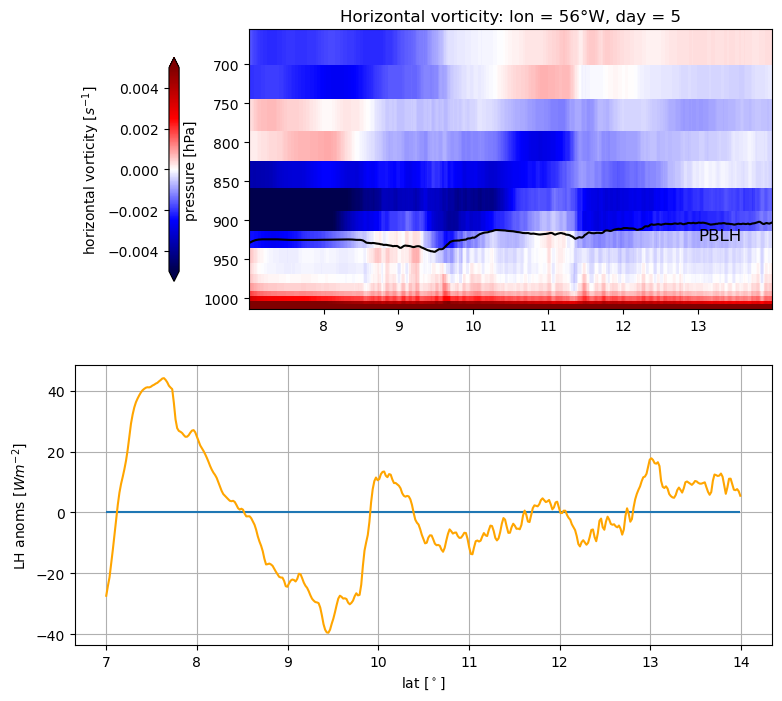

In [80]:
lev = int(18); day = int(5)

vertical = True
x = lat_M[vert_line[:,0],lon_verticalline] if vertical else lon_M[lat_horizontalline,hor_line[:,1]]
var = vort_vertline[day, 0:lev, :].magnitude if vertical else vort_horline[day, 0:lev, :].magnitude
xlab = r'lat [$^\circ$]' if vertical else r'lon [$^\circ$]'
title = f'Horizontal vorticity: lon = 56°W, day = {day}' if vertical else f'Horizontal vorticity at lat = 10°N, day = {day}'

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 8))  
ax1.invert_yaxis()


# plot for vorticity and PBLH

p1 = ax1.pcolormesh(x, mean_vert_pres[0:lev], var, \
               vmin=-0.005, vmax=0.005, cmap='seismic')


ax1.set_ylabel('pressure [hPa]')
ax1.set_title(title)
cbar = plt.colorbar(p1,ax=ax1, location='left', shrink=0.8, extend='both') 
cbar.set_label('horizontal vorticity [$s^{-1}$]')

#twin = ax1.twinx()
var_PBL = PBLH_vertline if vertical else PBLH_horline
ax1.plot(x, var_PBL[day,:], 'k'); ax1.text(13, 925, 'PBLH', fontsize=12)


### plot to have LH / dLH at hand

var_LH = LH_vertline if vertical else LH_horline
var_dLH = dLH_vertline if vertical else dLH_horline

ax2.plot(x, var_dLH[day,:], 'orange')
ax2.set_ylabel('LH anoms [$Wm^{-2}$]'); ax2.set_xlabel(xlab);
ax2.grid(); ax2.hlines(0, xmin=x[0], xmax=x[-1])

# on subdaily timescale?

In [11]:
# load W component - in m/s
U = xr.open_dataset(wrf_files[files_ls.index('U.nc')])
U = U['U'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))


V = xr.open_dataset(wrf_files[files_ls.index('V.nc')])
V = V['V'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))



In [13]:
U = (U[:,:,:,:-1]+U[:,:,:,1:])*0.5
V = (V[:,:,:-1,:]+V[:,:,1:,:])*0.5

U = U.where(sea_mask, drop=False)
V = V.where(sea_mask, drop=False)

In [15]:
# load W component - in m/s
W = xr.open_dataset(wrf_files[files_ls.index('W.nc')])
W = W['W'].sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))
W = W.where(sea_mask, drop=False)


lon_M = W['nav_lon_grid_M'].values
lat_M = W['nav_lat_grid_M'].values

W_inter = np.zeros_like(U)
for i in range(39):
    W_inter[:,i,:,:] = (W[:,i+1,:,:]+W[:,i,:,:])*0.5

In [16]:
# reading geopotential height
GPH_base = xr.open_dataset(wrf_files[files_ls.index('PHB.nc')])
GPH_base = GPH_base['PHB']/9.81

GPH = xr.open_dataset(wrf_files[files_ls.index('PH.nc')])
GPH = GPH.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))
GPH = GPH['PH']/9.81

GPH = GPH_base + GPH
GPH = GPH.transpose('time_counter', 'lev_W', 'y_grid_M', 'x_grid_M')
GPH = GPH.where(sea_mask, drop=False)

# GPH = GPH.groupby('time_counter.day').mean()

#GPH_base = GPH_base.where(sea_mask, drop=False)
del GPH_base

In [18]:
# vertical interpolation of geopotential
GPH_inter = np.zeros_like(U)
for i in range(39):
    GPH_inter[:,i,:,:] = (GPH[:,i+1,:,:]+GPH[:,i,:,:])*0.5

In [ ]:
'''vert_line = np.argwhere((lon_M==-55.983223) & (lat_M >=7) & (lat_M <=14))
hor_line = np.argwhere((lat_M==10.01075) & (lon_M >=-60) & (lon_M <=-53))'''

In [ ]:
'''# visualize what is going on along (-56, 7:14) and (-60:-53, 10)
lon_verticalline = int(np.unique(vert_line[:,1]))
w_vertline = W_inter[:,:,np.unique(vert_line[:,0]), lon_verticalline]

lat_horizontalline = int(np.unique(hor_line[:,0]))
w_horline = W_inter[:,:,lat_horizontalline, np.unique(hor_line[:,1])]
'''

In [ ]:
'''v_vertline = V[:,:,vert_line[:,0], vert_line[:,1]]; GPH_vert = GPH_inter[:,:,vert_line[:,0], vert_line[:,1]]
u_horline = U[:,:,hor_line[:,0], hor_line[:,1]];    GPH_hor  = GPH_inter[:,:,hor_line[:,0], hor_line[:,1]]'''

In [ ]:
dwdy = mpcalc.first_derivative(W*units('m/s'), axis=2,x=None, delta=2000.*units.meters) #, x=GPH_vert*units.meters)
dwdx = mpcalc.first_derivative(W*units('m/s'), axis=2, x=None, delta=2000.*units.meters) #, x=GPH_hor*units.meters)

dvdz = mpcalc.first_derivative(V*units('m/s'), axis=1, x=GPH_inter*units.meters)
dudz = mpcalc.first_derivative(U*units('m/s'), axis=1, x=GPH_inter*units.meters)

In [ ]:
eta = dwdy-dvdz
csi = dudz-dwdx 

LINK WITH LHF ANOMALIES?

In [20]:
wrf_hourly = path + 'Caraibes_WRF_3h_surf.nc'
ds_hourly = xr.open_dataset(wrf_hourly)
ds_hourly = ds_hourly.sel(time_counter=slice('2020-02-01T01:30:00.000000000', '2020-02-07T22:30:00.000000000'))

LH = ds_hourly['LH']   #.groupby('time_counter.day').mean()            
LH = LH.where(sea_mask, drop=False).values;
# LH_vertline = LH[:, vert_line[:,0],lon_verticalline]
# LH_horline = LH[:, lat_horizontalline,hor_line[:,1]]


In [22]:
LH = LH[::3,:,:]

In [23]:
s = 75   # CAREFUL!!

dLH = np.zeros(LH.shape)

for t in range(0,LH.shape[0]):
    if t % 10 == 0:
        print(t)
    # upscale using gaussian filter
    LH_ave = gm.nan_gaussian_filter(LH[t],s)                             
    dLH[t] = LH[t] - LH_ave

0
10
20
30
40
50


In [ ]:
#### PBLH
PBLH = ds_hourly['PBLH']              
PBLH = PBLH.where(sea_mask, drop=False)
PBLH = PBLH[::3,:,:]


In [ ]:
pdist_dLH, pdist_PBLH_dLH, pstd_PBLH_dLH, pstd_err_PBLH_dLH, pnpoints_PBLH_dLH, ppvalue_PBLH_dLH = \
distrib_2d(dLH, PBLH, perc_step, nbins, popmean, perc_fixbin='perc')

In [ ]:
### PBLH conversion to hPa
pdist_PBLH_dLH = mpcalc.height_to_pressure_std(pdist_PBLH_dLH*units.meters)

In [ ]:
pdist_dLH, pdist_eta, pstd_eta, pstderr_eta, pnpoints_eta, ppvalue_eta_sub = \
dist_3d_subsample(dLH, eta.magnitude, perc_step, nbins, popmean, nt, nttop, nskip, nskiptop, top=14, perc_fixbin='perc')

In [ ]:
mean_vert_pres = np.load('/venus/tesi_ale/data_EU/PRES/daily/FEB/mean_vert_pres.npy')

In [ ]:
# figure dBV or BV vs dSST bin - DAILY
p_level_plot = int(15)


x = pdist_dLH #if perc else dist_dsst_day
var = pdist_eta[0:p_level_plot,:]
# minval = -10. #if perc else -0.05
# maxval = -minval
title = 'Eta (along x) distributions'

fig, ax1 = plt.subplots(figsize=(10, 5))  
ax1.invert_yaxis()
p1 = ax1.pcolormesh(x, mean_vert_pres[0:p_level_plot], var, cmap='seismic')  # vmin=minval, vmax=maxval, )
ax1.set_xlabel('LH anomalies [W/m2]'); ax1.set_ylabel('pressure [hPa]')
plt.title(f'{title} - 3hr dLH vs eta and PBLH')
cbar = plt.colorbar(p1,ax=ax1, location='right', shrink=0.8, extend='both')  
cbar.set_label('Eta [$s^{-1}$]')


x_pbl = pdist_dLH #if perc else dist_dsst
var_pbl = pdist_PBLH_dLH #if perc else dist_PBLH_dsst
ax1.plot(x_pbl, var_pbl, 'k')
# ax1.text(0.4, 925, 'PBLH', fontsize=12)



# DEF punti significativi (pvalue < 0.05)
# pval = ppvalue_dBV_freq_day_sub[0:p_level_plot] #if perc else pvalue_dBV_freq_day_sub[0:p_level_plot]
# GPbin = mean_vert_pres[1:p_level_plot] - np.diff(mean_vert_pres[0:p_level_plot])*0.5
# signif_Lcorr_H = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# dsstbin = np.zeros((len(mean_vert_pres[0:p_level_plot])-1,len(x)-1))
# for h in range(0,len(mean_vert_pres[0:p_level_plot])-1):
#     cond1 = pval[h,:-1] > 0.05
#     cond2 = np.abs(var[h,:-1]) < 0.1*np.nanmean(np.abs(var))
#     cond = (cond1) | (cond2)
# #     cond = cond1
#     signif_Lcorr_H[h,:] = np.zeros(len(x)-1) + np.nan
#     signif_Lcorr_H[h, cond] = GPbin[h]
#     dsstbin[h,:] = x[1:] - np.diff(x)*0.5
    
# plt.scatter(dsstbin,signif_Lcorr_H,  s=0.7, color='k')


path_img = '/venus/tesi_ale/img_EU/BV/daily/FEB/' if perc else '/venus/tesi_ale/img_EU/BV/daily/FEB/'
filename = path_img + 'pdist_dsst_dBV_lowtropo.png' if perc else path_img + 'bins_dsst_dBV_lowtropo.png'
#plt.savefig(filename)
print(filename)
del filename